In [54]:
%%html
<style>
.h1_cell, .just_text {
    box-sizing: border-box;
    padding-top:5px;
    padding-bottom:5px;
    font-family: "Times New Roman", Georgia, Serif;
    font-size: 125%;
    line-height: 22px; /* 5px +12px + 5px */
    text-indent: 25px;
    background-color: #fbfbea;
    padding: 10px;
}

hr { 
    display: block;
    margin-top: 0.5em;
    margin-bottom: 0.5em;
    margin-left: auto;
    margin-right: auto;
    border-style: inset;
    border-width: 2px;
}
</style>

<h1>
<center>
Module 8
</center>
</h1>
<div class=h1_cell>
<p>
We are shifting focus this week. We will start treating sentences more like a linguist would. We will break a sentence into parts-of-speech (POS). And then revisit regular experssion matching, but now using the extra information that POS gives us.
<p>
The ultimate goal will be to pull out what are called relations from a sentence. A relation is a triple of [noun-phrase, verb, noun phrase]. For instance, ['the big dog', 'ate', 'the dirty bone']. Pulling relations like this out of text is a big research area. Once you have relations, you can start using AI techniques to reason about them or do question answering, e.g., "Who ate the dirty bone?".
<p>
To start, here are the POS tags that nltk gives us. Each word will be given one and only one of these tags.
</div>

<div class=h1_cell>
<p>
Here are sentences we will be testing on. I pulled them from the Frankenstien wikipedia page. For each of them, I would like to pull out a relation that captures the meaning of the sentence.
</div>

In [1]:
sentences = [
    'Victor Frankenstein builds the creature in his laboratory',

    'The creature is 8 feet tall',  # tricky

    'the monster wanders through the wilderness',  # tricky

    'He finds brief solace beside a remote cottage inhabited by a family of peasants',

    'Eavesdropping, the creature familiarizes himself with their lives and learns to speak',  # tricky

    "The creature eventually introduces himself to the family's blind father",

    'the creature rescues a peasant girl from a river.',

    "He finds Frankenstein's journal in the pocket of the jacket he found in the laboratory",

    "The monster kills Victor's younger brother William upon learning of the boy's relation to his hated creator.",

    "Frankenstein builds a female creature.",

    "the monster kills Frankenstein's best friend Henry Clerva.",

    "the monster boards the ship.",

    "The monster has also been analogized to an oppressed class",

    "the monster is the tragic result of uncontrolled technology."
    ]

In [2]:
import nltk
from nltk.tree import Tree
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/stevekent/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/stevekent/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/stevekent/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

<div class=h1_cell>
<p>
Let's work on the first sentence. First I will tokenize it like we have been doing in past weeks. But then I will use somethning called a POS tagger to add basic parts of speech to each word.
</div>

In [3]:
s = sentences[0]
print(s)
print('='*10)
data_tok = nltk.word_tokenize(s) #tokenization
print(data_tok)
print('='*10)
data_pos = nltk.pos_tag(data_tok) #POS tagging
print(data_pos)

Victor Frankenstein builds the, creature in his laboratory
['Victor', 'Frankenstein', 'builds', 'the', ',', 'creature', 'in', 'his', 'laboratory']
[('Victor', 'NNP'), ('Frankenstein', 'NNP'), ('builds', 'VBZ'), ('the', 'DT'), (',', ','), ('creature', 'NN'), ('in', 'IN'), ('his', 'PRP$'), ('laboratory', 'NN')]


<div class=h1_cell>
<p>
You can match up the pos tags in table above.
</div>

<h2>
Big new idea: chunking
</h2>
<div class=h1_cell>
<p>
What we have after pos_tag is a flat structure. All we really have done is gone word by word and added the pos to the word. So we have a list of tuples instead of a list of words.
<p>
What we want now is to structure this a bit more. I'd like to group words into noun-phrases or other collections of words that make sense for my problem. First I'll use a chunker that is built into nltk. It looks at various forms of nouns and tags them with more information. Let's take a look.
</div>

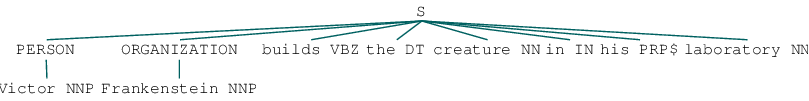

In [58]:
chunk = nltk.ne_chunk(data_pos)  # notice takes pos tagged version and not raw text
chunk

<div class=h1_cell>
<p>
You can see we have new nodes in the tree: PERSON and ORGANIZATION. So the ne_chunk chunker knows about lots of different names of entities. And it can give you a more abstract view of your words. In some cases, this may be all you want. You are just looking through lots of tweets for people or organizations being mentioned: ne_chunk can flag them for you.
<p>
Also notice that ne_chunk does not combine names well, guessing that Frankenstein is an organization. There is an interesting discussion here on how to post-process ne_chunk results to get more accurate tags: https://stackoverflow.com/questions/24398536/named-entity-recognition-with-regular-expression-nltk. For one, to group Victor and Frankenstein under the single node PERSON.
<p>
Jargon alert: the ne_chunk chunker works in a research area called Named Entity Recognition or NER. It can be a tricker problem than you might think to classify words and phrases in a sentence into useful categories.
</div>

<div class=h1_cell>
<p>
Let's look at the components of chunk. You can see that some items are Trees and some are leaves.
</div>

In [59]:
for x in chunk:
    print((type(x) == Tree, x))

(True, Tree('PERSON', [('Victor', 'NNP')]))
(True, Tree('ORGANIZATION', [('Frankenstein', 'NNP')]))
(False, ('builds', 'VBZ'))
(False, ('the', 'DT'))
(False, ('creature', 'NN'))
(False, ('in', 'IN'))
(False, ('his', 'PRP$'))
(False, ('laboratory', 'NN'))


<div class=h1_cell>
<p>
If you view chunk as the big tree, then there are 2 sub-trees and 6 leaves under it.
</div>

<h2>
DIY: chunking
</h2>
<div class=h1_cell>
<p>
It turns out we will need to build our own chunker to chunk the pieces of a relation. Before getting to that, let's take a look at building a verb-phrase chunker. It is pretty cool. All we need to do is write a regular-expression type pattern to chunk on. Look at the example below. A chunk pattern consists of a name for the chunk (MY_VP) and a pattern within {}. The pattern itself is a mixture of pos tags and vanilla re operators. My pattern below should match a Verb that is 3rd person singular present (VBZ). Then 0 or more of any type of elements. Then a singular noun (NN).
</div>

In [60]:
vb_pattern = "MY_VP: {<VBZ><.*>*?<NN>}"

<div class=h1_cell>
<p>
We need a special chunker that allows us to define our own chunking patterns.
</div>

In [61]:
vb_chunker = nltk.RegexpParser(vb_pattern)

<div class=h1_cell>
<p>
Test it out.
</div>

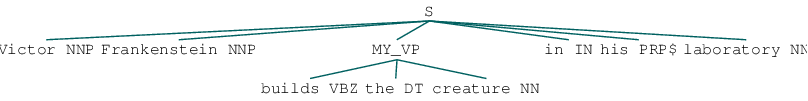

In [62]:
vb_chunked = vb_chunker.parse(data_pos)  # remember chunkers want pos tagged sentences as input
vb_chunked

In [63]:
for x in vb_chunked:
    print(x)

('Victor', 'NNP')
('Frankenstein', 'NNP')
(MY_VP builds/VBZ the/DT creature/NN)
('in', 'IN')
('his', 'PRP$')
('laboratory', 'NN')


<h2>
Noun-phrase (NP) chunker (version 0)
</h2>
<div class=h1_cell>
<p>
The goal is to build a relation which is a triple consisting of a tuple (NP, VERB, NP) for each sentence in sentences. So our first step is to build a chunking pattern that will tag noun-phrases in a sentence. I am going to give you a start below.
<p>
Notice I am using VERB instead of MY_VP. I found it more difficult to work with verb phrases so I will not use them. But if you want to play around with them, no problem. I could easily see catching some set of adverbs preceding a verb and tagging that as an ADV_VERB or somesuch.
</div>

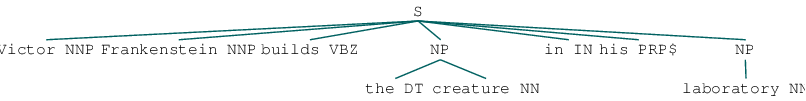

In [64]:
np_chunker = nltk.RegexpParser(r'''
    NP:
    {<DT>?<JJ>*<NN>} # NP chunk is determiner (optional), adjectives (optional) and noun
   ''')
chunk1 = np_chunker.parse(data_pos)

chunk1

<h2>
Hmmmm
</h2>
<div class=h1_cell>
<p>
We got "the creature" and have the verb but missed "Victor Frankenstein". Have to get back to that.
<p>
I am going to want to do some experimentation with patterns so I am going to create function that will make my life easier. I'll pass in raw text and then chunker I want to test out.
<p>
Notice that I have a chunking pipeline going. I like this about nltk. I can first chunk to tag noun phrases. Then I can pass that to next chunker in line to tag relations. Cool.
</div>

In [65]:

def build_relation(text, chunker):
    
    #chunk the text with chunker
    chunks = chunker.parse(nltk.pos_tag(nltk.word_tokenize(text)))
    
    print(chunks)  # debugging
    
    #Now re-chunk looking for our triples. Call the chunk REL for relation
    chunker2 = nltk.RegexpParser(r'''
                   REL:
                   {<NP><VBZ><NP>}
                   ''')
    relation_chunk = chunker2.parse(chunks)
    
    for t in relation_chunk:
        if type(t) != Tree: continue
        if t.label() == 'REL':
            return (t[0], t[1], t[2])
            
    return tuple([]) 

In [66]:
#Here it is again so I can play with it

rel_chunker = nltk.RegexpParser(r'''
    NP:
    {<DT>?<JJ>*<NN>} # chunk determiner (optional), adjectives (optional) and noun
   ''')

In [67]:
build_relation(sentences[0], rel_chunker)

(S
  Victor/NNP
  Frankenstein/NNP
  builds/VBZ
  (NP the/DT creature/NN)
  in/IN
  his/PRP$
  (NP laboratory/NN))


()

<h2>
Challenge 1
</h2>
<div class=h1_cell>
<p>
Solve the problem. Modify rel_chunker so that it builds the target relation for sentence 0. And remember, that Victor liked to be called by his full name: Victor Dennis Frankenstein. I just made that up but you get the drift.
</div>

In [68]:
rel_chunker2 = nltk.RegexpParser(r'''
    NP:
    {(<NNP><NNP>?<NNP>?)|(<DT>?<JJ>*<NN>)}
   ''')

In [69]:
build_relation(sentences[0], rel_chunker2)

(S
  (NP Victor/NNP Frankenstein/NNP)
  builds/VBZ
  (NP the/DT creature/NN)
  in/IN
  his/PRP$
  (NP laboratory/NN))


(Tree('NP', [('Victor', 'NNP'), ('Frankenstein', 'NNP')]),
 ('builds', 'VBZ'),
 Tree('NP', [('the', 'DT'), ('creature', 'NN')]))

<h2>
Let's try on all the sentences
</h2>
<div class=h1_cell>
<p>
See how many we can pull relations from
</div>

In [70]:
all_relations = []
for i,s in enumerate(sentences):
    relation = build_relation(s, rel_chunker2)
    all_relations.append((i, relation))
    print(relation)
    print('===============')

(S
  (NP Victor/NNP Frankenstein/NNP)
  builds/VBZ
  (NP the/DT creature/NN)
  in/IN
  his/PRP$
  (NP laboratory/NN))
(Tree('NP', [('Victor', 'NNP'), ('Frankenstein', 'NNP')]), ('builds', 'VBZ'), Tree('NP', [('the', 'DT'), ('creature', 'NN')]))
(S (NP The/DT creature/NN) is/VBZ 8/CD feet/NNS tall/JJ)
()
(S
  (NP the/DT monster/NN)
  wanders/NNS
  through/IN
  (NP the/DT wilderness/NN))
()
(S
  He/PRP
  finds/VBZ
  brief/JJ
  solace/JJ
  beside/IN
  (NP a/DT remote/JJ cottage/NN)
  inhabited/VBN
  by/IN
  (NP a/DT family/NN)
  of/IN
  peasants/NNS)
()
(S
  (NP Eavesdropping/NN)
  ,/,
  (NP the/DT creature/NN)
  familiarizes/VBZ
  himself/PRP
  with/IN
  their/PRP$
  lives/NNS
  and/CC
  learns/NNS
  to/TO
  speak/VB)
()
(S
  (NP The/DT creature/NN)
  eventually/RB
  introduces/VBZ
  himself/PRP
  to/TO
  (NP the/DT family/NN)
  's/POS
  (NP blind/NN)
  (NP father/NN))
()
(S
  (NP the/DT creature/NN)
  rescues/VBZ
  (NP a/DT peasant/JJ girl/NN)
  from/IN
  (NP a/DT river/NN)
  ./.)
(Tree

<h2>
Challenge 2
</h2>
<div class=h1_cell>
<p>
I'd like you to modify the pattern to capture the relation in as many of these sentences as you can. Some mods can be made easily. Some mods will be difficult - we are dealing with all the complexities of English grammar here.
<p>
If you feel you just can't write a pattern that works in general, go ahead and write it for the specific case, i.e., may only work with one sentence in sentences. Hey, it's a start.
</div>

In [172]:
my_chunker = nltk.RegexpParser(r'''
    NP:
    {(<NNP><NNP>?<NNP>?<POS>?<JJR>?<JJS>?<NN>?<NNP>?)|(<PRP>?<RB>?<VBN>?<VBN>?<TO>?<DT>?<JJ>?<NN><RB>?)|(<CD>?<NNS><JJ>?)|(<PRP>?<IN>?<PRP\$><NNS>)}
   ''')

In [173]:
all_relations = []
for i,s in enumerate(sentences):
    relation = build_relation(s, my_chunker)
    all_relations.append((i, relation))
    print(relation)
    print('===============')

(S
  (NP Victor/NNP Frankenstein/NNP)
  builds/VBZ
  (NP the/DT creature/NN)
  in/IN
  his/PRP$
  (NP laboratory/NN))
(Tree('NP', [('Victor', 'NNP'), ('Frankenstein', 'NNP')]), ('builds', 'VBZ'), Tree('NP', [('the', 'DT'), ('creature', 'NN')]))
(S (NP The/DT creature/NN) is/VBZ (NP 8/CD feet/NNS tall/JJ))
(Tree('NP', [('The', 'DT'), ('creature', 'NN')]), ('is', 'VBZ'), Tree('NP', [('8', 'CD'), ('feet', 'NNS'), ('tall', 'JJ')]))
(S
  (NP the/DT monster/NN)
  (NP wanders/NNS)
  through/IN
  (NP the/DT wilderness/NN))
()
(S
  He/PRP
  finds/VBZ
  brief/JJ
  solace/JJ
  beside/IN
  (NP a/DT remote/JJ cottage/NN)
  inhabited/VBN
  by/IN
  (NP a/DT family/NN)
  of/IN
  (NP peasants/NNS))
()
(S
  (NP Eavesdropping/NN)
  ,/,
  (NP the/DT creature/NN)
  familiarizes/VBZ
  (NP himself/PRP with/IN their/PRP$ lives/NNS)
  and/CC
  (NP learns/NNS)
  to/TO
  speak/VB)
(Tree('NP', [('the', 'DT'), ('creature', 'NN')]), ('familiarizes', 'VBZ'), Tree('NP', [('himself', 'PRP'), ('with', 'IN'), ('their', 

<h2>
Challenge 3
</h2>
<div class=h1_cell>
<p>
Use the relations to generate new sentences. Maybe we can write summaries of a sentence by just generating words from our triples. Here are some examples I generated from triples.
<pre>
'Victor Frankenstein builds the creature.'

'Frankenstein found the laboratory.'

'The monster has an oppressed class.'
</pre>
Write a function that given one of your relations, will produce a sentence as a string.
</div>

In [226]:
def summarizer(triple):
    sentence = ""
    for word in triple:
        if type(word) == nltk.tree.Tree:
            for detail in word:
                sentence += detail[0] + " "
        else:
            sentence += word[0] + " "
    if len(sentence) > 0:
        sentence = sentence.capitalize()
        return sentence.rstrip() + "."
    else: 
        return "No Sentence Made"

In [227]:
for s in sentences:
    rel = build_relation(s, my_chunker)
    summary = summarizer(rel)
    print(rel)
    print(summary)
    print('='*10)

(S
  (NP Victor/NNP Frankenstein/NNP)
  builds/VBZ
  (NP the/DT creature/NN)
  in/IN
  his/PRP$
  (NP laboratory/NN))
(Tree('NP', [('Victor', 'NNP'), ('Frankenstein', 'NNP')]), ('builds', 'VBZ'), Tree('NP', [('the', 'DT'), ('creature', 'NN')]))
Victor frankenstein builds the creature.
(S (NP The/DT creature/NN) is/VBZ (NP 8/CD feet/NNS tall/JJ))
(Tree('NP', [('The', 'DT'), ('creature', 'NN')]), ('is', 'VBZ'), Tree('NP', [('8', 'CD'), ('feet', 'NNS'), ('tall', 'JJ')]))
The creature is 8 feet tall.
(S
  (NP the/DT monster/NN)
  (NP wanders/NNS)
  through/IN
  (NP the/DT wilderness/NN))
()
No Sentence Made
(S
  He/PRP
  finds/VBZ
  brief/JJ
  solace/JJ
  beside/IN
  (NP a/DT remote/JJ cottage/NN)
  inhabited/VBN
  by/IN
  (NP a/DT family/NN)
  of/IN
  (NP peasants/NNS))
()
No Sentence Made
(S
  (NP Eavesdropping/NN)
  ,/,
  (NP the/DT creature/NN)
  familiarizes/VBZ
  (NP himself/PRP with/IN their/PRP$ lives/NNS)
  and/CC
  (NP learns/NNS)
  to/TO
  speak/VB)
(Tree('NP', [('the', 'DT'), (

<h2>
Closing notes
</h2>
<div class=h1_cell>
<p>
Extracting triples like we are doing is an active area of research. What researchers hope to do is send their extractors crawling over web pages. Pull triples out of the sentences on a page. These triples can act like a type of knowledge base. So it is one way to give the computer intelligence - extract information from the billions of pages on the web.
<p>
Easy to say but hard to do. As we have seen, we will need more sophisticated chunkers to actually pull the pieces out of a compex sentence.
<p>
Jargon alert: extracting triples like we have been doing is called Information Extraction or IE.
</div>
